<a href="https://colab.research.google.com/github/cesaenv/buscaminas/blob/main/4_1_Selecci%C3%B3nDescriptores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte 4.1. Selección de descriptores

Lo bueno de seleccionar los descriptores es que la información relevante del dataset no se perdería, pero si los descriptores están diversos, entonces algunos que no deberían omitirse se omiten. Hay dos formas de realizarlo:
-	Selección secuencial hacia atrás

-	Selección secuencial hacia adelante


### 1. Dataset

Antes de comenzar vamos a cargar las librerías que serán necesarias. Con respecto al notebook 1, habría que cargar numpy y pandas.


In [1]:
import numpy as np
import pandas as pd

A parte de esas dos librerías que nos acompañan a lo largo de todo este entregable, también habría que cargar la librería propia de los Árboles de decisión ya que según el punto 3 es el modelo que más se adapta y mejor precisión tiene ante nuestros datos

In [2]:
#Árboles de decisión
from sklearn.tree import DecisionTreeClassifier

Además, aparecen dos nuevas librerías [matplotlib](https://matplotlib.org/) y [seaborn](https://seaborn.pydata.org/). La versión de seaborn instalada en el entorno de Google Colaboratory no incluye algunos gráficos, por lo que lo primero que vamos a hacer es descargar la última versión de esta librería usando el siguiente comando.

In [3]:
!pip install seaborn -Uq
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.4 MB/s eta 0:00:00


Seguiremos con el dataset train.csv. Un dataset que intenta predecir la actividad que estaba realizando un paciente a partir de distintos datos, los correspondientes a las columnas del dataset.

In [4]:
df = pd.read_csv('train.csv')

Nuestro dataset constituye a una recopilación de datos por cada paciente, por lo que vamos a describir cada una de las columnas (o datos). A continuación se muestra la descripción de las distintas características de este dataset.


|  Name  | Description | Value Type |
|---         |---       |---    
| **SL** | Nivel de azúcar | Numerical |
| **EEG** | Ratio monitor EEG | Numerical |
| **BP** | Presión en sangre | Numerical |
| **HR** | Ratio de latidos | Numerical |
| **CIRCULATION** | Circulación de sangre | Numerical |

Por otro lado, *ACTIVITY* es la predicción de la actividad que estaba realizando un paciente a partir de los anteriores datos. Es el que tenemos que predecir. Posibles valores:

|  Valor  | Description
|---         |---         
| **0** | De pie |
| **1** | Caminando |
| **2** | Sentado |
| **3** | Cayendo |
| **4** | Con calambres |
| **5** | Corriendo |

Para evaluar todos los conjuntos de la misma manera, tendré que evaluarlos con la misma partición del dataset. Por ello, realizamos ya la partición.

Primero cargamos la librería:

In [5]:
from sklearn.model_selection import train_test_split

Luego tenemos que dividir a nuestro conjunto de entrenamiento en los propios datos y las correspondientes etiquetas:

In [6]:
X =  df.values[:,:-1]
Y =  df.values[:,-1]

Y luego hacemos la partición, asignando al conjunto test un 20%

In [7]:
(trainData, testData, trainLabels, testLabels) = train_test_split(X,Y,test_size=0.25, random_state=42)

In [35]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
trainDataNorm = mms.fit_transform(trainData)
testDataNorm = mms.transform(testData)

In [36]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
trainDataSTD = stdsc.fit_transform(trainData)
testDataSTD = stdsc.transform(testData)

Además, como en la realización del notebook me molestaban los warnings he decidido ignorarlos:

In [8]:
import warnings

# Ignorar todos los warnings
warnings.filterwarnings("ignore")

In [9]:
#Árboles de decisión
from sklearn.tree import DecisionTreeClassifier

##Visualizando las características importantes del dataset

Como hemos visto en prácticas anteriores, el análisis exploratorio de datos (AED) suele ser el primer paso antes de entrenar un modelo de aprendizaje. En el resto de este apartado veremos algunas técnicas útiles de AED que pueden ayudar a detectar la presencia de [valores atípicos](https://es.wikipedia.org/wiki/Valor_at%C3%ADpico), la distribución de los datos, y las relaciones entre los descriptores.

El primer paso va a consistir en crear un [diagrama de dispersión](https://en.wikipedia.org/wiki/Scatter_plot) que nos va a ayudar a visualizar las correlaciones entre pares de atributos.

In [10]:
numerical = list(set(df.columns)) #nos devolvería el nombre de las columnas

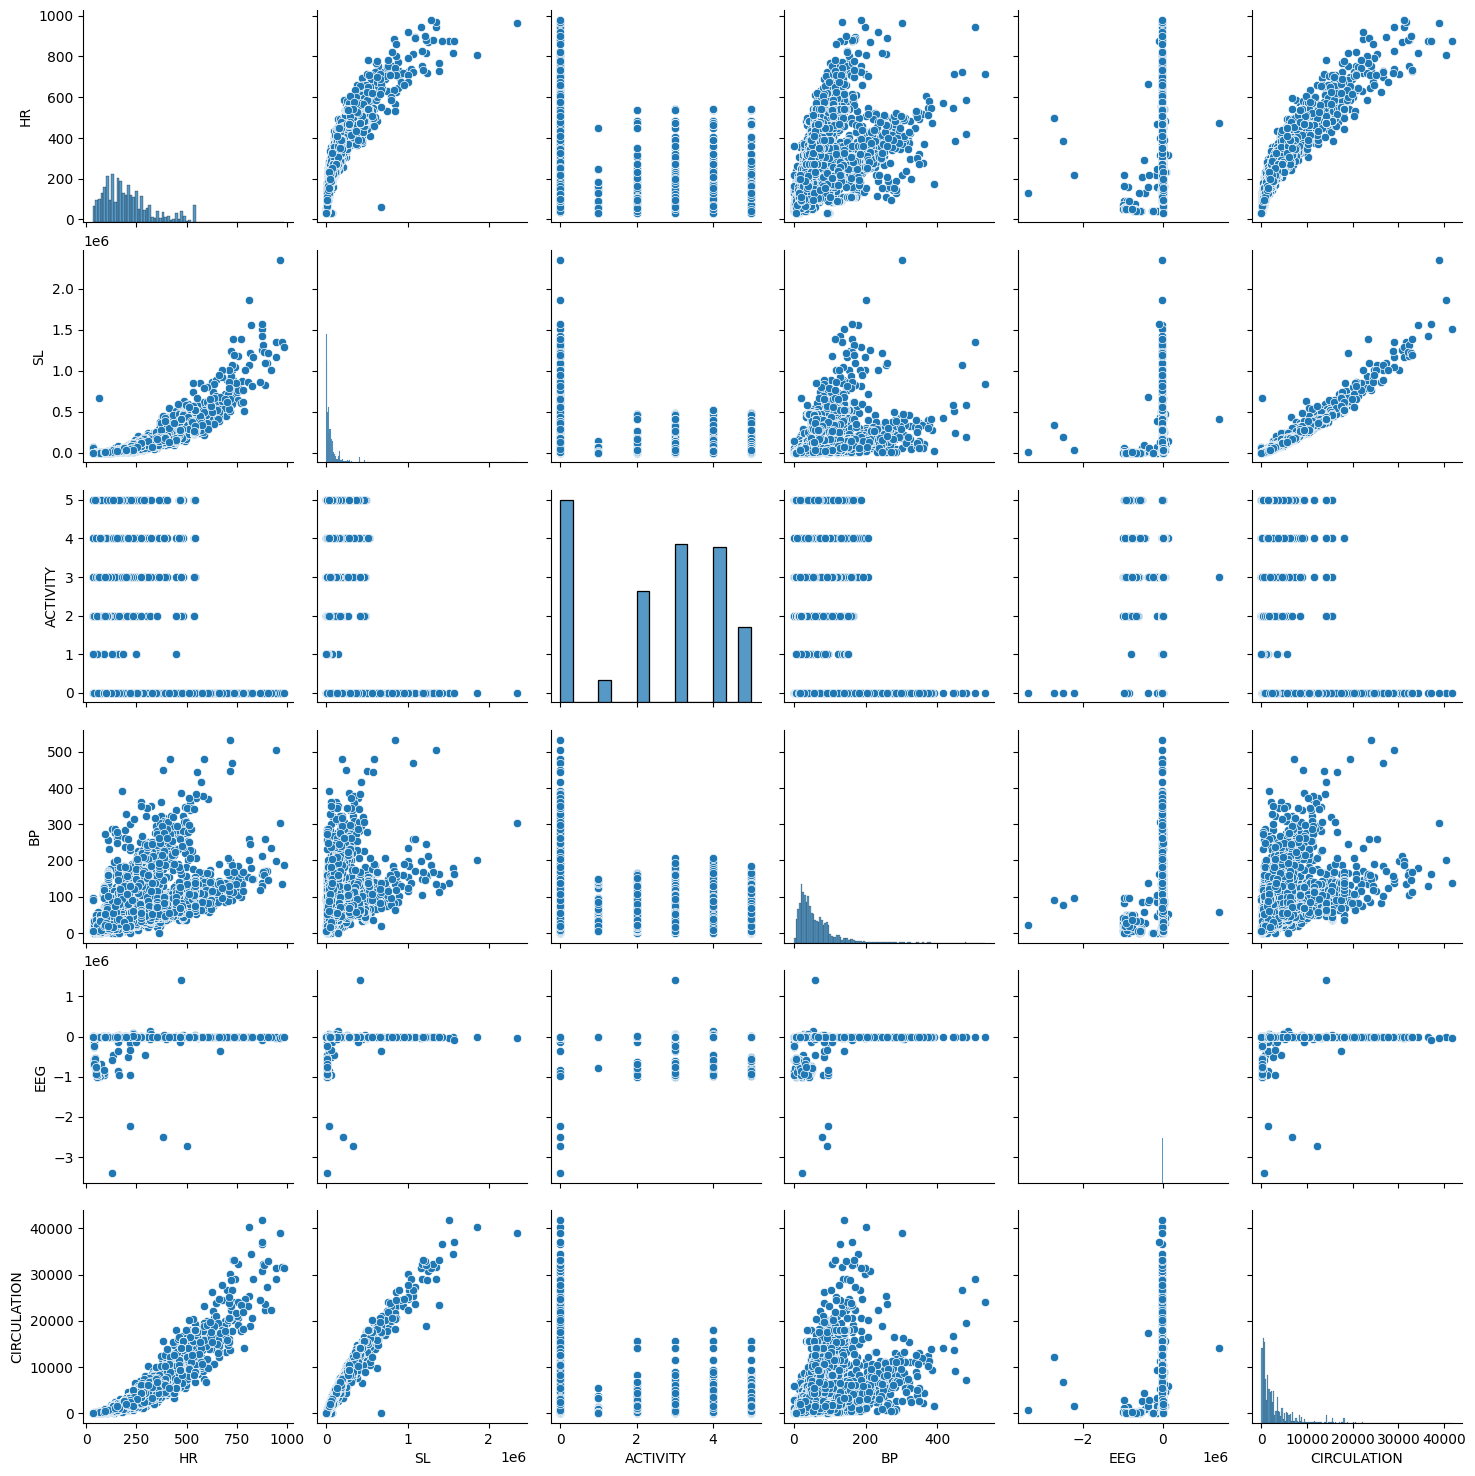

In [11]:
# Cambiamos la configuración a png ya que la generación de diagramas con SVG puede ser muy lenta en este caso
%config InlineBackend.figure_format = 'png'
sns.pairplot(df[numerical]);

In [12]:
# Volvemos a cambiar la configuración
%config InlineBackend.figure_format = 'svg'

Para cuantificar la relación lineal entre descriptores, se suele utilizar una matriz de correlación. Una matriz de correlación está muy relacionada con la matriz de convarianza utilizada para el algoritmo de análisis de componentes principales.

La matriz de correlación es una matriz cuadrada que contiene los coeficientes de correlación de Pearson, que sirven para medir la dependencia entre pares de descriptores. El [coeficiente de correlación de Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) toma valores entre -1 y 1. Dos descriptores tienen una perfecta correlación positiva (dos atribuos tienen una correlación positiva si al aumentar el valor de un atributo, el otro también aumenta) si el coeficiente de correlación de Pearson vale 1, no tienen correlación (dos atribuos no tienen correlación si el valor de un atributo no influye en el otro) si vale 0, y una perfecta correlación negativa (dos atribuos tienen una correlación negativa si al aumentar el valor de un atributo, el otro disminuye de manera proporcional) si vale -1.

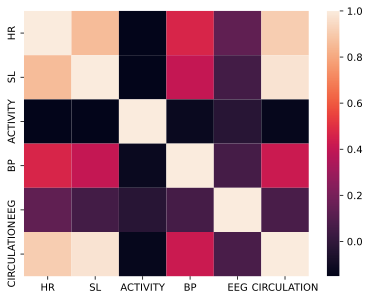

In [13]:
corr_matrix = df[numerical].corr()
sns.heatmap(corr_matrix);

Del diagrama anterior podemos concluir los descriptores con cuadrados más claros son los posibles a descartar, ya que su información no nos añade mucho más que la información que da el resto de descriptores.

##Selección secuencial hacia atrás

Se trata de reducir la dimensión (N) con la mínima pérdida, es decir, eliminar los descriptores hasta obtener un N deseado. De esta forma es necesario definir una función criterio a minimizar. El proceso sería en ir eliminando descriptores que causan menor pérdida de rendimiento.

### Descriptores importantes

Este algoritmo no está implementado por defecto en sklearn, pero lo tienes disponible en el fichero sbs.py.

Necesitamos primero descargar el fichero sbs con la funcionalidad necesaria.

In [14]:
!wget https://raw.githubusercontent.com/IA1819/Code/master/sbs1.py -O sbs.py

--2024-03-26 22:38:24--  https://raw.githubusercontent.com/IA1819/Code/master/sbs1.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1691 (1.7K) [text/plain]
Saving to: ‘sbs.py’

sbs.py              100%[===================>]   1.65K  --.-KB/s    in 0s      

2024-03-26 22:38:24 (17.6 MB/s) - ‘sbs.py’ saved [1691/1691]



In [18]:
#librerías necesarias
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sbs import SBS
%matplotlib inline

Construimos el clasificador segun la parte 4

In [21]:
modelo = DecisionTreeClassifier(criterion="entropy", max_depth=None,
                                min_samples_split=11, min_samples_leaf=1)

In [22]:
sbs= SBS(modelo,k_features=1)
sbs.fit(trainData,trainLabels)

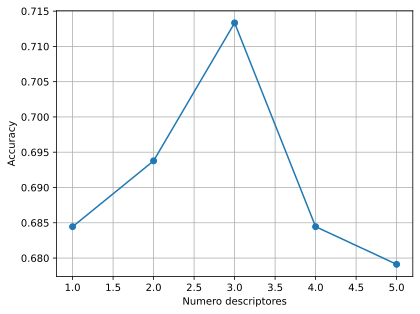

In [24]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat,sbs.scores_,marker='o')
plt.ylabel('Accuracy')
plt.xlabel('Numero descriptores')
plt.grid()
plt.show()

In [27]:
k5 = list(sbs.subsets_[3])
print(df.columns[1:][k5])

Index(['CIRCULATION', 'ACTIVITY'], dtype='object')


In [37]:
#normal
modelo.fit(trainData,trainLabels)
print('Training accuracy:', modelo.score(trainData,trainLabels))
print('Test accuracy:', modelo.score(testData,testLabels))

Training accuracy: 0.8659851094566063
Test accuracy: 0.675


In [38]:
#normalizado
modelo.fit(trainDataNorm,trainLabels)
print('Training accuracy:', modelo.score(trainDataNorm,trainLabels))
print('Test accuracy:', modelo.score(testDataNorm,testLabels))

Training accuracy: 0.8658739859984442
Test accuracy: 0.6693333333333333


In [39]:
#estandarizado
modelo.fit(trainDataNorm,trainLabels)
print('Training accuracy:', modelo.score(trainDataNorm,trainLabels))
print('Test accuracy:', modelo.score(testDataNorm,testLabels))

Training accuracy: 0.8653183687076342
Test accuracy: 0.6676666666666666


In [41]:
#con los 3 descriptores más importantes
modelo.fit(trainData[:,k5],trainLabels)
print('Training accuracy:', modelo.score(trainData[:,k5],trainLabels))
print('Test accuracy:', modelo.score(testData[:,k5],testLabels))

Training accuracy: 0.7290810090010001
Test accuracy: 0.71


### Relevancia de los descriptores:

Una técnica que también resulta útil para seleccionar descriptores relevantes a partir de un dataset consiste en utilizar [_random forests_](http://scikit-learn.org/stable/modules/ensemble.html#forest) un método en el cual se entrenan varios árboles de decisión y se organiza una votación entre esos modelos para decidir la predicción.

Utilizando los random forest podemos ver la importancia de cada descriptor usando el atributo `feature_importances_` que está accesible después de entrenar uno de estos clasificadores. Ejecutando el siguiente código se entrenará uno de estos modelos utilizando 1000 árboles de decisión y se obtendrá un ranking de los 13 descriptores.

Comenzamos cargando las libreráis necesarias.

In [42]:
from sklearn.ensemble import RandomForestClassifier

Obtenemos el nombre de cada descriptor.

In [43]:
etiquetas_descriptores = df.columns[1:]

Construimos el random forest con los mismos atributos que los que poníamos en el Árbol de Decisión

In [44]:
forest = RandomForestClassifier(criterion="entropy", max_depth=None,
                                min_samples_split=11, min_samples_leaf=1)

Entrenamos el modelo. Notar que usamos directamente el dataset sin estandarizar, esto es debido a que los árboles de decisión no están afectados por la escala de los atributos.

In [45]:
forest.fit(trainData,trainLabels)

RandomForestClassifier(criterion='entropy', min_samples_split=11)

Obtenemos la relevancia de cada descriptor y los índices para ordenar de mayor a menor dichas relevancias.

In [46]:
relevancias = forest.feature_importances_
indices = np.argsort(relevancias)[::-1]

Por último mostramos la importancia de cada descriptor.

In [49]:
for f in range(trainData.shape[1]):
    print("%2d) %-*s %f" % (f+1,30,etiquetas_descriptores[indices[f]],relevancias[indices[f]]))

 1) EEG                            0.228355
 2) CIRCULATION                    0.214514
 3) ACTIVITY                       0.208996
 4) BP                             0.193765
 5) HR                             0.154370


Vamos a mostrar un gráfico con la relevancia de cada descriptor.

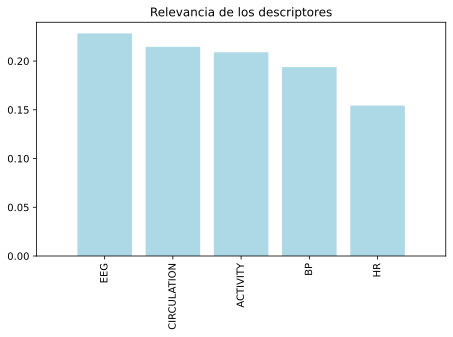

In [51]:
plt.title('Relevancia de los descriptores')
plt.bar(range(trainData.shape[1]),relevancias[indices],color='lightblue',align='center')
plt.xticks(range(trainData.shape[1]),etiquetas_descriptores[indices],rotation=90)
plt.xlim([-1,trainData.shape[1]])
plt.tight_layout()
plt.show()

Para este caso, como hay pocos descriptores, lo que haré será eliminar uno de los descriptores que más se relacionen entre sí (eliminar uno entre "SL" y "CIRCULATION"); y hacer un

##Selección secuencial hacia adelante


Se trata de añadir descriptores hasta obtener un N deseado. De esta forma es necesario definir una función criterio a maximizar. El proceso sería que en cada paso se añade el descriptor que proporciona más información según la función anterior.